# Figure 4

**Figure 4.** Domain and time averages of shortwave, longwave, and net CRH. Profiles are shown for the (a) shallow cumulus, (b) WCB ascent, (c) WCB cyclonic outflow, and (d) WCB anticyclonic outflow regions. The ICON CRH is shown in dashed lines, and the CRH derived from the offline reference 1D radiative transfer calculation is shown in solid lines. Note the different x-axes between panels (a) and (b-d).

---
@ Behrooz Keshtgar, KIT 2023

## 1- load python packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import colorlegend
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import matplotlib.colors as mcolors
from matplotlib import cm
import warnings
warnings.filterwarnings("ignore")

For reference, print package versions to screen:

In [2]:
print('xarrary:   ', xr.__version__)
print('numpy:     ', np.__version__)
import matplotlib; print('matplotlib:', matplotlib.__version__); del matplotlib

xarrary:    0.16.0
numpy:      1.23.5
matplotlib: 3.3.0


**Since datasets are large, I use DASK to speed up my analysis**

In [3]:
import dask
from dask.distributed import Client, progress, wait
dask.config.config.get('distributed').get('dashboard').update({'link':'{JUPYTERHUB_SERVICE_PREFIX}/proxy/{port}/status'})
client = Client()
client

<Client: 'tcp://127.0.0.1:38581' processes=16 threads=256, memory=252.72 GB>

## 2- Loading datasets

In [4]:
# Dictionary for loading datasets for the 4 simulations
simdict = {
         'LC1-LES-471x667km-lon25-lat40-300m-0006' : {'res':'300', 'radiation':4, 'mphy':4}, # Only cloud radiation
         'LC1-LES-471x667km-lon40-lat44-300m-0003' : {'res':'300', 'radiation':4, 'mphy':4}, # Only cloud radiation
         'LC1-LES-471x667km-lon30-lat53-300m-0005' : {'res':'300', 'radiation':4, 'mphy':4}, # Only cloud radiation
         'LC1-LES-471x667km-lon50-lat48-300m-0004' : {'res':'300', 'radiation':4, 'mphy':4}, # Only cloud radiation
          }

In [5]:
# Loading icon datasets
def load_simulations(num):
    d_icon = []
    sim = list(simdict.keys())[num]
    print('Working on loading data for', sim)
    # loading all subdomains
    path_i = '/work/bb1135/icon_output/'+sim+'/input4libradtran/'
    for time in ['20220105T100033Z','20220105T103033Z','20220105T110033Z','20220105T113033Z','20220105T120033Z','20220105T123033Z','20220105T130033Z','20220105T133033Z','20220105T140033Z']:
        ds_a = []
        for dom in range(1,37):
            ds = xr.open_mfdataset(path_i+'icon2_'+str(dom)+'_'+time+'.nc',concat_dim='lon')[['ddt_radlwnw','ddt_radlwcs','ddt_radlw','ddt_radswnw','ddt_radswcs','ddt_radsw']].isel(height=slice(0,140))
            ds_a.append(ds) 
        # concat along x dim
        ds_j=[]        
        for j in range(0,36,6):
            ds = xr.concat([ds_a[j],ds_a[j+1],ds_a[j+2],ds_a[j+3],ds_a[j+4],ds_a[j+5]],dim='lon')
            ds_j.append(ds)
        # concat along y dim    
        ds_temp = xr.concat([ds_j[0],ds_j[1],ds_j[2],ds_j[3],ds_j[4],ds_j[5]],dim='lat') 
        # change units to K/day 
        ds_temp['ddt_radlwnw'] = ds_temp['ddt_radlwnw']*86400 
        ds_temp['ddt_radlwcs'] = ds_temp['ddt_radlwcs']*86400
        ds_temp['ddt_radlw'] = ds_temp['ddt_radlw']*86400
        ds_temp['ddt_radswnw'] = ds_temp['ddt_radswnw']*86400
        ds_temp['ddt_radswcs'] = ds_temp['ddt_radswcs']*86400
        ds_temp['ddt_radsw'] = ds_temp['ddt_radsw']*86400

        ds_temp.coords['lon'] = np.arange(0,344*6)
        ds_temp.coords['lat'] = np.arange(0,281*6)
        ds_temp.coords['time'] = time

        d_icon.append(ds_temp)

    # merge them together in time
    ds_icon = xr.concat([d_icon[0],d_icon[1],d_icon[2],d_icon[3],d_icon[4],d_icon[5],d_icon[6]
                     ,d_icon[7],d_icon[8]],dim='time')
    ds = ds_icon.chunk(chunks={'time': 1, 'height': 50})
    return ds
#-------------------------------------------------------------------------------------------------
ds_icon1=load_simulations(0)
ds_icon2=load_simulations(1)
ds_icon3=load_simulations(2)
ds_icon4=load_simulations(3)

Working on loading data for LC1-LES-471x667km-lon25-lat40-300m-0006
Working on loading data for LC1-LES-471x667km-lon40-lat44-300m-0003
Working on loading data for LC1-LES-471x667km-lon30-lat53-300m-0005
Working on loading data for LC1-LES-471x667km-lon50-lat48-300m-0004


In [6]:
# all libradtrn simulation using ice parametrization of Fu
def load_simulations1(num):
    ds_list = []
    sim = list(simdict.keys())[num]
    print('Working on loading data for', sim)
    path = '/work/bb1135/icon_output/'+sim+'/input4libradtran/libradtran/output_netcdf/'
    for solver in ['ipa3d']:
        # loop over sources (thermal/solar)
        for source in ['thermal','solar']:
            # loop over sim types
            for nsim in ['01']: # different ice param
                ds = xr.open_mfdataset(path+'ds_librad2_05T*_'+source+'_'+solver+'_'+nsim+'.nc',concat_dim='time',combine='nested',
                                           chunks={'height': 50},parallel=True).isel(height=slice(0,140))
                ds.attrs['sim_name'] = 'ds_librad_'+source+'_'+solver+'_'+nsim+''
                ds_list.append(ds)
    return ds_list                
#-------------------------------------
ds_lib1=load_simulations1(0)
ds_lib2=load_simulations1(1)
ds_lib3=load_simulations1(2)
ds_lib4=load_simulations1(3)

## height values at full-levels
z_ifc = xr.open_dataset('/work/bb1135/icon_output/LC1-LES-471x667km-lon40-lat44-300m-0003/icon-atm3d_ML_20220105T120033Z.nc')["z_ifc"].isel(ncells=20000)
z_fl  = ((z_ifc - z_ifc.diff('height_3')/2).values)*1e-3 # km
# select between index 0:140
z_fl2  = z_fl[10:150][::-1]

Working on loading data for LC1-LES-471x667km-lon25-lat40-300m-0006
Working on loading data for LC1-LES-471x667km-lon40-lat44-300m-0003
Working on loading data for LC1-LES-471x667km-lon30-lat53-300m-0005
Working on loading data for LC1-LES-471x667km-lon50-lat48-300m-0004


## 3- Average profiles of CRH

In [7]:
# excluding boundaries and takin domain average
# icon
for var in ['ddt_radlw','ddt_radsw']:
    ds_icon1[var+'_mean'] = ds_icon1[var].isel(lon=slice(10,ds_icon1.lon.size-10),lat=slice(5,ds_icon1.lat.size-5)).mean(dim=['lat','lon','time']).values
    ds_icon2[var+'_mean'] = ds_icon2[var].isel(lon=slice(10,ds_icon2.lon.size-10),lat=slice(5,ds_icon2.lat.size-5)).mean(dim=['lat','lon','time']).values
    ds_icon3[var+'_mean'] = ds_icon3[var].isel(lon=slice(10,ds_icon3.lon.size-10),lat=slice(5,ds_icon3.lat.size-5)).mean(dim=['lat','lon','time']).values
    ds_icon4[var+'_mean'] = ds_icon4[var].isel(lon=slice(10,ds_icon4.lon.size-10),lat=slice(5,ds_icon4.lat.size-5)).mean(dim=['lat','lon','time']).values

# libradtran
for i in range(2):
    ds_lib1[i]['ddt_radlw_mean'] = ds_lib1[i]['ddt_radlw'].isel(lon=slice(10,ds_lib1[i].lon.size-10),lat=slice(5,ds_lib1[i].lat.size-5)).mean(dim=['lat','lon','time']).values
    ds_lib2[i]['ddt_radlw_mean'] = ds_lib2[i]['ddt_radlw'].isel(lon=slice(10,ds_lib2[i].lon.size-10),lat=slice(5,ds_lib2[i].lat.size-5)).mean(dim=['lat','lon','time']).values
    ds_lib3[i]['ddt_radlw_mean'] = ds_lib3[i]['ddt_radlw'].isel(lon=slice(10,ds_lib3[i].lon.size-10),lat=slice(5,ds_lib3[i].lat.size-5)).mean(dim=['lat','lon','time']).values
    ds_lib4[i]['ddt_radlw_mean'] = ds_lib4[i]['ddt_radlw'].isel(lon=slice(10,ds_lib4[i].lon.size-10),lat=slice(5,ds_lib4[i].lat.size-5)).mean(dim=['lat','lon','time']).values

## 4- Plot

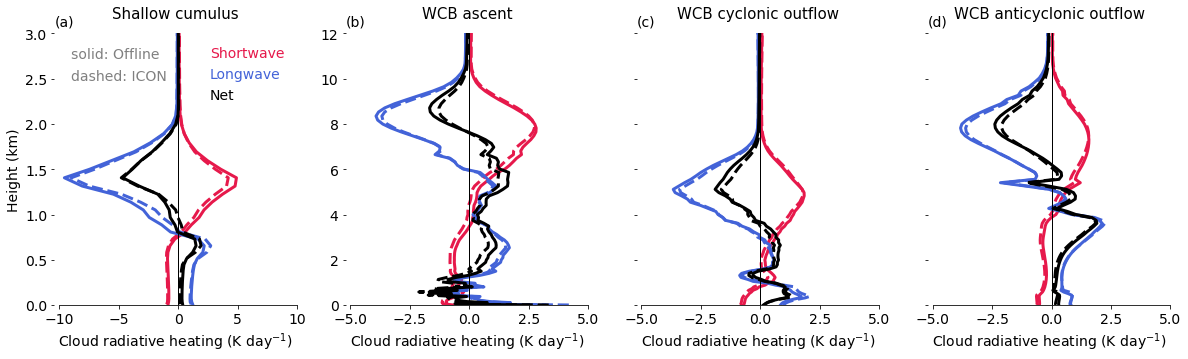

In [9]:
# plot
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
i = 0

for ax in axes.flat:
    ax.tick_params(labelsize=14)
    
    if i == 0:
        ax.spines['top'].set_color('none')
        ax.spines['right'].set_color('none')
        ax.spines['left'].set_color('none')
        
        ax.plot(ds_lib1[1]['ddt_radlw_mean'],z_fl2,color='#e6194B',label='Shortwave',lw=3)
        ax.plot(ds_icon1['ddt_radsw_mean'],z_fl2,color='#e6194B',linestyle='dashed',lw=3)
        
        ax.plot(ds_lib1[0]['ddt_radlw_mean'],z_fl2,color='#4363d8',label='Longwave',lw=3)
        ax.plot(ds_icon1['ddt_radlw_mean'],z_fl2,color='#4363d8',linestyle='dashed',lw=3)
        
        ax.plot(ds_lib1[0]['ddt_radlw_mean'].values+ds_lib1[1]['ddt_radlw_mean'].values,z_fl2,color='#000000',label='Net',lw=3)
        ax.plot(ds_icon1['ddt_radlw_mean'].values+ds_icon1['ddt_radsw_mean'].values,z_fl2,color='#000000',linestyle='dashed',lw=3)
        
        ax.axvline(x=0, ymin=0.0, ymax=1,c='black', lw=1)
        ax.set_xlabel('Cloud radiative heating (K day$^{-1}$)', fontsize=14)#,labelpad=10)
        ax.set_ylabel('Height (km)', fontsize=14)
        #ax.set_yticklabels([])
        ax.text(0.0, 1.03, '(a)', transform=ax.transAxes, 
            size=14)
        
        ax.spines['bottom'].set_bounds(-10,10)
        ax.set_xticks(np.linspace(-10,10,5))
        ax.set_xlim([-10.4,10])
        
        lg=colorlegend.color_legend(ax,loc=1,fsize=14)
        ax.set_title('Shallow cumulus', fontsize=15,pad=15)
        ax.set_ylim([0,3])
        
        ax.text(-9, 2.85, "solid: Offline", color="gray", size=14, va="top")
        ax.text(-9, 2.6, "dashed: ICON", color="gray", size=14, va="top")
        
    
    if i == 1:
        ax.spines['top'].set_color('none')
        ax.spines['right'].set_color('none')
        ax.spines['left'].set_color('none')
        
        ax.plot(ds_lib2[1]['ddt_radlw_mean'],z_fl2,color='#e6194B',lw=3)
        ax.plot(ds_icon2['ddt_radsw_mean'],z_fl2,color='#e6194B',linestyle='dashed',lw=3)
        
        ax.plot(ds_lib2[0]['ddt_radlw_mean'],z_fl2,color='#4363d8',lw=3)
        ax.plot(ds_icon2['ddt_radlw_mean'],z_fl2,color='#4363d8',linestyle='dashed',lw=3)
        
        ax.plot(ds_lib2[0]['ddt_radlw_mean'].values+ds_lib2[1]['ddt_radlw_mean'].values,z_fl2,color='#000000',lw=3)
        ax.plot(ds_icon2['ddt_radlw_mean'].values+ds_icon2['ddt_radsw_mean'].values,z_fl2,color='#000000',linestyle='dashed',lw=3)
        
        ax.axvline(x=0, ymin=0.0, ymax=1,c='black', lw=1)
        ax.set_xlabel('Cloud radiative heating (K day$^{-1}$)', fontsize=14)#,labelpad=10)
        #ax.set_ylabel('Height (km)', fontsize=14)
        #ax.set_yticklabels([])
        ax.text(0.0, 1.03, '(b)', transform=ax.transAxes, 
            size=14)
        
        ax.spines['bottom'].set_bounds(-5,5)
        ax.set_xticks(np.linspace(-5,5,5))
        ax.set_xlim([-5.2,5])
        
        #lg=colorlegend.color_legend(ax,loc=1,fsize=14)
        ax.set_title('WCB ascent', fontsize=15,pad=15)
        ax.set_ylim([0,12])
        
    if i == 2:
        
        ax.spines['top'].set_color('none')
        ax.spines['right'].set_color('none')
        ax.spines['left'].set_color('none')
        
        ax.plot(ds_lib3[1]['ddt_radlw_mean'],z_fl2,color='#e6194B',label='Shortwave',lw=3)
        ax.plot(ds_icon3['ddt_radsw_mean'],z_fl2,color='#e6194B',linestyle='dashed',lw=3)
        
        ax.plot(ds_lib3[0]['ddt_radlw_mean'],z_fl2,color='#4363d8',label='Longwave',lw=3)
        ax.plot(ds_icon3['ddt_radlw_mean'],z_fl2,color='#4363d8',linestyle='dashed',lw=3)
        
        ax.plot(ds_lib3[0]['ddt_radlw_mean'].values+ds_lib3[1]['ddt_radlw_mean'].values,z_fl2,color='#000000',lw=3)
        ax.plot(ds_icon3['ddt_radlw_mean'].values+ds_icon3['ddt_radsw_mean'].values,z_fl2,color='#000000',linestyle='dashed',lw=3)
        
        ax.axvline(x=0, ymin=0.0, ymax=1,c='black', lw=1)
        ax.set_xlabel('Cloud radiative heating (K day$^{-1}$)', fontsize=14)#,labelpad=10)
        #ax.set_ylabel('Height (km)', fontsize=14)
        ax.set_yticklabels([])
        ax.text(0.0, 1.03, '(c)', transform=ax.transAxes, 
            size=14)
        
        ax.spines['bottom'].set_bounds(-5,5)
        ax.set_xticks(np.linspace(-5,5,5))
        ax.set_xlim([-5.2,5])
        
        #lg=colorlegend.color_legend(ax,loc=5,fsize=11)
        ax.set_title('WCB cyclonic outflow', fontsize=15,pad=15)
        ax.set_ylim([0,12])
        
    if i == 3:
        
        ax.spines['top'].set_color('none')
        ax.spines['right'].set_color('none')
        ax.spines['left'].set_color('none')
        
        ax.plot(ds_lib4[1]['ddt_radlw_mean'],z_fl2,color='#e6194B',label='Shortwave',lw=3)
        ax.plot(ds_icon4['ddt_radsw_mean'],z_fl2,color='#e6194B',linestyle='dashed',lw=3)
        
        ax.plot(ds_lib4[0]['ddt_radlw_mean'],z_fl2,color='#4363d8',label='Longwave',lw=3)
        ax.plot(ds_icon4['ddt_radlw_mean'],z_fl2,color='#4363d8',linestyle='dashed',lw=3)
        
        ax.plot(ds_lib4[0]['ddt_radlw_mean'].values+ds_lib4[1]['ddt_radlw_mean'].values,z_fl2,color='#000000',lw=3)
        ax.plot(ds_icon4['ddt_radlw_mean'].values+ds_icon4['ddt_radsw_mean'].values,z_fl2,color='#000000',linestyle='dashed',lw=3)
        
        ax.axvline(x=0, ymin=0.0, ymax=1,c='black', lw=1)
        ax.set_xlabel('Cloud radiative heating (K day$^{-1}$)', fontsize=14)#,labelpad=10)
        #ax.set_ylabel('Height (km)', fontsize=14)
        ax.set_yticklabels([])
        ax.text(0.0, 1.03, '(d)', transform=ax.transAxes, 
            size=14)
        
        ax.spines['bottom'].set_bounds(-5,5)
        ax.set_xticks(np.linspace(-5,5,5))
        ax.set_xlim([-5.2,5])
        
        #lg=colorlegend.color_legend(ax,loc=5,fsize=11)
        ax.set_title('WCB anticyclonic outflow', fontsize=15,pad=15)
        ax.set_ylim([0,12])    
        
    i = i + 1    
    
fig.subplots_adjust(wspace=0.2,hspace=0.35) 
plt.savefig('figure4.pdf', bbox_inches = 'tight')
plt.savefig('figure4.png', bbox_inches = 'tight',dpi=300)

In [111]:
client.close()